In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare Data

In [6]:
# Specify data URI
URI = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [7]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                              

In [11]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

In [33]:
from tensorflow.keras.layers import Layer
model._layers=[
    layer for layer in model._layers if isinstance(layer,Layer)
]

In [30]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2870 - y1_output_loss: 0.0981 - y2_output_loss: 0.1889 - y1_output_root_mean_squared_error: 0.3132 - y2_output_root_mean_squared_error: 0.4346 - val_loss: 1.5273 - val_y1_output_loss: 0.2214 - val_y2_output_loss: 1.3059 - val_y1_output_root_mean_squared_error: 0.4705 - val_y2_output_root_mean_squared_error: 1.1427
Epoch 2/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2615 - y1_output_loss: 0.0975 - y2_output_loss: 0.1641 - y1_output_root_mean_squared_error: 0.3122 - y2_output_root_mean_squared_error: 0.4050 - val_loss: 0.8907 - val_y1_output_loss: 0.2384 - val_y2_output_loss: 0.6523 - val_y1_output_root_mean_squared_error: 0.4882 - val_y2_output_root_mean_squared_error: 0.8076
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 0.2944 - y1_output_loss: 0.0951 - y2_output_loss: 0.1993 - y1_output_root_mean_squared_error: 0.3084 - y2_output_root_mean_squared_error: 0.4464 

Epoch 22/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2541 - y1_output_loss: 0.0992 - y2_output_loss: 0.1549 - y1_output_root_mean_squared_error: 0.3149 - y2_output_root_mean_squared_error: 0.3936 - val_loss: 0.8614 - val_y1_output_loss: 0.1869 - val_y2_output_loss: 0.6746 - val_y1_output_root_mean_squared_error: 0.4323 - val_y2_output_root_mean_squared_error: 0.8213
Epoch 23/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4479 - y1_output_loss: 0.1309 - y2_output_loss: 0.3171 - y1_output_root_mean_squared_error: 0.3617 - y2_output_root_mean_squared_error: 0.5631 - val_loss: 0.7877 - val_y1_output_loss: 0.1651 - val_y2_output_loss: 0.6227 - val_y1_output_root_mean_squared_error: 0.4063 - val_y2_output_root_mean_squared_error: 0.7891
Epoch 24/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2654 - y1_output_loss: 0.0978 - y2_output_loss: 0.1676 - y1_output_root_mean_squared_error: 0.3127 - y2_output_root_mean_squared_error: 0.40

Epoch 43/500
62/62 [==============================] - 0s 916us/step - loss: 0.3078 - y1_output_loss: 0.1152 - y2_output_loss: 0.1926 - y1_output_root_mean_squared_error: 0.3394 - y2_output_root_mean_squared_error: 0.4388 - val_loss: 0.9164 - val_y1_output_loss: 0.2021 - val_y2_output_loss: 0.7143 - val_y1_output_root_mean_squared_error: 0.4496 - val_y2_output_root_mean_squared_error: 0.8451
Epoch 44/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2735 - y1_output_loss: 0.1004 - y2_output_loss: 0.1730 - y1_output_root_mean_squared_error: 0.3169 - y2_output_root_mean_squared_error: 0.4160 - val_loss: 0.8564 - val_y1_output_loss: 0.1533 - val_y2_output_loss: 0.7032 - val_y1_output_root_mean_squared_error: 0.3915 - val_y2_output_root_mean_squared_error: 0.8386
Epoch 45/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2828 - y1_output_loss: 0.0998 - y2_output_loss: 0.1830 - y1_output_root_mean_squared_error: 0.3159 - y2_output_root_mean_squared_error: 0.

Epoch 64/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2523 - y1_output_loss: 0.0930 - y2_output_loss: 0.1593 - y1_output_root_mean_squared_error: 0.3049 - y2_output_root_mean_squared_error: 0.3991 - val_loss: 0.8910 - val_y1_output_loss: 0.1662 - val_y2_output_loss: 0.7248 - val_y1_output_root_mean_squared_error: 0.4077 - val_y2_output_root_mean_squared_error: 0.8513
Epoch 65/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3552 - y1_output_loss: 0.1056 - y2_output_loss: 0.2496 - y1_output_root_mean_squared_error: 0.3249 - y2_output_root_mean_squared_error: 0.4996 - val_loss: 0.9477 - val_y1_output_loss: 0.1864 - val_y2_output_loss: 0.7613 - val_y1_output_root_mean_squared_error: 0.4317 - val_y2_output_root_mean_squared_error: 0.8725
Epoch 66/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3247 - y1_output_loss: 0.1031 - y2_output_loss: 0.2216 - y1_output_root_mean_squared_error: 0.3212 - y2_output_root_mean_squared_error: 0.47

Epoch 85/500
62/62 [==============================] - 0s 990us/step - loss: 0.2388 - y1_output_loss: 0.0912 - y2_output_loss: 0.1476 - y1_output_root_mean_squared_error: 0.3021 - y2_output_root_mean_squared_error: 0.3842 - val_loss: 1.1880 - val_y1_output_loss: 0.2077 - val_y2_output_loss: 0.9803 - val_y1_output_root_mean_squared_error: 0.4557 - val_y2_output_root_mean_squared_error: 0.9901
Epoch 86/500
62/62 [==============================] - 0s 950us/step - loss: 0.3744 - y1_output_loss: 0.1101 - y2_output_loss: 0.2643 - y1_output_root_mean_squared_error: 0.3318 - y2_output_root_mean_squared_error: 0.5141 - val_loss: 0.7489 - val_y1_output_loss: 0.1738 - val_y2_output_loss: 0.5751 - val_y1_output_root_mean_squared_error: 0.4169 - val_y2_output_root_mean_squared_error: 0.7584
Epoch 87/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2452 - y1_output_loss: 0.0915 - y2_output_loss: 0.1537 - y1_output_root_mean_squared_error: 0.3024 - y2_output_root_mean_squared_error: 

Epoch 106/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3002 - y1_output_loss: 0.1026 - y2_output_loss: 0.1976 - y1_output_root_mean_squared_error: 0.3203 - y2_output_root_mean_squared_error: 0.4446 - val_loss: 1.0535 - val_y1_output_loss: 0.2756 - val_y2_output_loss: 0.7779 - val_y1_output_root_mean_squared_error: 0.5250 - val_y2_output_root_mean_squared_error: 0.8820
Epoch 107/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3448 - y1_output_loss: 0.1205 - y2_output_loss: 0.2243 - y1_output_root_mean_squared_error: 0.3471 - y2_output_root_mean_squared_error: 0.4736 - val_loss: 1.1577 - val_y1_output_loss: 0.2352 - val_y2_output_loss: 0.9225 - val_y1_output_root_mean_squared_error: 0.4850 - val_y2_output_root_mean_squared_error: 0.9605
Epoch 108/500
62/62 [==============================] - 0s 916us/step - loss: 0.3108 - y1_output_loss: 0.1055 - y2_output_loss: 0.2053 - y1_output_root_mean_squared_error: 0.3249 - y2_output_root_mean_squared_error:

Epoch 127/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3017 - y1_output_loss: 0.1173 - y2_output_loss: 0.1844 - y1_output_root_mean_squared_error: 0.3425 - y2_output_root_mean_squared_error: 0.4294 - val_loss: 0.7634 - val_y1_output_loss: 0.1670 - val_y2_output_loss: 0.5964 - val_y1_output_root_mean_squared_error: 0.4086 - val_y2_output_root_mean_squared_error: 0.7723
Epoch 128/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2274 - y1_output_loss: 0.0926 - y2_output_loss: 0.1348 - y1_output_root_mean_squared_error: 0.3043 - y2_output_root_mean_squared_error: 0.3672 - val_loss: 0.9760 - val_y1_output_loss: 0.3338 - val_y2_output_loss: 0.6422 - val_y1_output_root_mean_squared_error: 0.5778 - val_y2_output_root_mean_squared_error: 0.8014
Epoch 129/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2257 - y1_output_loss: 0.0936 - y2_output_loss: 0.1321 - y1_output_root_mean_squared_error: 0.3059 - y2_output_root_mean_squared_error: 0

Epoch 148/500
62/62 [==============================] - 0s 956us/step - loss: 0.2745 - y1_output_loss: 0.1000 - y2_output_loss: 0.1744 - y1_output_root_mean_squared_error: 0.3163 - y2_output_root_mean_squared_error: 0.4176 - val_loss: 1.3001 - val_y1_output_loss: 0.3040 - val_y2_output_loss: 0.9961 - val_y1_output_root_mean_squared_error: 0.5514 - val_y2_output_root_mean_squared_error: 0.9981
Epoch 149/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2773 - y1_output_loss: 0.0981 - y2_output_loss: 0.1792 - y1_output_root_mean_squared_error: 0.3132 - y2_output_root_mean_squared_error: 0.4233 - val_loss: 0.7084 - val_y1_output_loss: 0.1925 - val_y2_output_loss: 0.5159 - val_y1_output_root_mean_squared_error: 0.4387 - val_y2_output_root_mean_squared_error: 0.7183
Epoch 150/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2209 - y1_output_loss: 0.0910 - y2_output_loss: 0.1299 - y1_output_root_mean_squared_error: 0.3017 - y2_output_root_mean_squared_error:

Epoch 169/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2591 - y1_output_loss: 0.0910 - y2_output_loss: 0.1681 - y1_output_root_mean_squared_error: 0.3016 - y2_output_root_mean_squared_error: 0.4100 - val_loss: 0.7433 - val_y1_output_loss: 0.2048 - val_y2_output_loss: 0.5385 - val_y1_output_root_mean_squared_error: 0.4525 - val_y2_output_root_mean_squared_error: 0.7338
Epoch 170/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2419 - y1_output_loss: 0.0971 - y2_output_loss: 0.1448 - y1_output_root_mean_squared_error: 0.3116 - y2_output_root_mean_squared_error: 0.3805 - val_loss: 0.7360 - val_y1_output_loss: 0.1672 - val_y2_output_loss: 0.5688 - val_y1_output_root_mean_squared_error: 0.4088 - val_y2_output_root_mean_squared_error: 0.7542
Epoch 171/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1940 - y1_output_loss: 0.0838 - y2_output_loss: 0.1102 - y1_output_root_mean_squared_error: 0.2895 - y2_output_root_mean_squared_error: 0

Epoch 190/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2164 - y1_output_loss: 0.0920 - y2_output_loss: 0.1244 - y1_output_root_mean_squared_error: 0.3033 - y2_output_root_mean_squared_error: 0.3526 - val_loss: 0.7869 - val_y1_output_loss: 0.2248 - val_y2_output_loss: 0.5621 - val_y1_output_root_mean_squared_error: 0.4741 - val_y2_output_root_mean_squared_error: 0.7497
Epoch 191/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2663 - y1_output_loss: 0.0984 - y2_output_loss: 0.1679 - y1_output_root_mean_squared_error: 0.3136 - y2_output_root_mean_squared_error: 0.4098 - val_loss: 0.8907 - val_y1_output_loss: 0.2160 - val_y2_output_loss: 0.6747 - val_y1_output_root_mean_squared_error: 0.4648 - val_y2_output_root_mean_squared_error: 0.8214
Epoch 192/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2148 - y1_output_loss: 0.0856 - y2_output_loss: 0.1291 - y1_output_root_mean_squared_error: 0.2926 - y2_output_root_mean_squared_error: 0

Epoch 211/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2008 - y1_output_loss: 0.0787 - y2_output_loss: 0.1220 - y1_output_root_mean_squared_error: 0.2806 - y2_output_root_mean_squared_error: 0.3493 - val_loss: 0.8714 - val_y1_output_loss: 0.1831 - val_y2_output_loss: 0.6883 - val_y1_output_root_mean_squared_error: 0.4279 - val_y2_output_root_mean_squared_error: 0.8297
Epoch 212/500
62/62 [==============================] - 0s 973us/step - loss: 0.2770 - y1_output_loss: 0.1071 - y2_output_loss: 0.1699 - y1_output_root_mean_squared_error: 0.3273 - y2_output_root_mean_squared_error: 0.4122 - val_loss: 0.7320 - val_y1_output_loss: 0.1617 - val_y2_output_loss: 0.5703 - val_y1_output_root_mean_squared_error: 0.4021 - val_y2_output_root_mean_squared_error: 0.7552
Epoch 213/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1921 - y1_output_loss: 0.0771 - y2_output_loss: 0.1150 - y1_output_root_mean_squared_error: 0.2776 - y2_output_root_mean_squared_error:

Epoch 232/500
62/62 [==============================] - 0s 995us/step - loss: 0.1959 - y1_output_loss: 0.0769 - y2_output_loss: 0.1190 - y1_output_root_mean_squared_error: 0.2773 - y2_output_root_mean_squared_error: 0.3450 - val_loss: 0.6544 - val_y1_output_loss: 0.1543 - val_y2_output_loss: 0.5001 - val_y1_output_root_mean_squared_error: 0.3929 - val_y2_output_root_mean_squared_error: 0.7072
Epoch 233/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2063 - y1_output_loss: 0.0801 - y2_output_loss: 0.1262 - y1_output_root_mean_squared_error: 0.2830 - y2_output_root_mean_squared_error: 0.3553 - val_loss: 0.7743 - val_y1_output_loss: 0.1911 - val_y2_output_loss: 0.5833 - val_y1_output_root_mean_squared_error: 0.4371 - val_y2_output_root_mean_squared_error: 0.7637
Epoch 234/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2604 - y1_output_loss: 0.0873 - y2_output_loss: 0.1731 - y1_output_root_mean_squared_error: 0.2955 - y2_output_root_mean_squared_error:

Epoch 253/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1825 - y1_output_loss: 0.0751 - y2_output_loss: 0.1074 - y1_output_root_mean_squared_error: 0.2740 - y2_output_root_mean_squared_error: 0.3278 - val_loss: 1.3481 - val_y1_output_loss: 0.2090 - val_y2_output_loss: 1.1391 - val_y1_output_root_mean_squared_error: 0.4571 - val_y2_output_root_mean_squared_error: 1.0673
Epoch 254/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4034 - y1_output_loss: 0.1130 - y2_output_loss: 0.2905 - y1_output_root_mean_squared_error: 0.3361 - y2_output_root_mean_squared_error: 0.5390 - val_loss: 0.7549 - val_y1_output_loss: 0.1942 - val_y2_output_loss: 0.5607 - val_y1_output_root_mean_squared_error: 0.4407 - val_y2_output_root_mean_squared_error: 0.7488
Epoch 255/500
62/62 [==============================] - 0s 960us/step - loss: 0.2087 - y1_output_loss: 0.0904 - y2_output_loss: 0.1183 - y1_output_root_mean_squared_error: 0.3006 - y2_output_root_mean_squared_error:

Epoch 274/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1694 - y1_output_loss: 0.0767 - y2_output_loss: 0.0926 - y1_output_root_mean_squared_error: 0.2770 - y2_output_root_mean_squared_error: 0.3044 - val_loss: 0.6613 - val_y1_output_loss: 0.1652 - val_y2_output_loss: 0.4962 - val_y1_output_root_mean_squared_error: 0.4064 - val_y2_output_root_mean_squared_error: 0.7044
Epoch 275/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2206 - y1_output_loss: 0.0788 - y2_output_loss: 0.1419 - y1_output_root_mean_squared_error: 0.2807 - y2_output_root_mean_squared_error: 0.3766 - val_loss: 0.8094 - val_y1_output_loss: 0.2054 - val_y2_output_loss: 0.6040 - val_y1_output_root_mean_squared_error: 0.4532 - val_y2_output_root_mean_squared_error: 0.7772
Epoch 276/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2018 - y1_output_loss: 0.0789 - y2_output_loss: 0.1229 - y1_output_root_mean_squared_error: 0.2809 - y2_output_root_mean_squared_error: 0

Epoch 295/500
62/62 [==============================] - 0s 983us/step - loss: 0.1744 - y1_output_loss: 0.0758 - y2_output_loss: 0.0985 - y1_output_root_mean_squared_error: 0.2754 - y2_output_root_mean_squared_error: 0.3139 - val_loss: 0.6471 - val_y1_output_loss: 0.1557 - val_y2_output_loss: 0.4914 - val_y1_output_root_mean_squared_error: 0.3946 - val_y2_output_root_mean_squared_error: 0.7010
Epoch 296/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1656 - y1_output_loss: 0.0680 - y2_output_loss: 0.0976 - y1_output_root_mean_squared_error: 0.2607 - y2_output_root_mean_squared_error: 0.3124 - val_loss: 1.0834 - val_y1_output_loss: 0.1799 - val_y2_output_loss: 0.9035 - val_y1_output_root_mean_squared_error: 0.4241 - val_y2_output_root_mean_squared_error: 0.9505
Epoch 297/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1595 - y1_output_loss: 0.0690 - y2_output_loss: 0.0905 - y1_output_root_mean_squared_error: 0.2627 - y2_output_root_mean_squared_error:

Epoch 316/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2227 - y1_output_loss: 0.0891 - y2_output_loss: 0.1336 - y1_output_root_mean_squared_error: 0.2985 - y2_output_root_mean_squared_error: 0.3656 - val_loss: 0.7267 - val_y1_output_loss: 0.1558 - val_y2_output_loss: 0.5709 - val_y1_output_root_mean_squared_error: 0.3947 - val_y2_output_root_mean_squared_error: 0.7556
Epoch 317/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1714 - y1_output_loss: 0.0719 - y2_output_loss: 0.0995 - y1_output_root_mean_squared_error: 0.2682 - y2_output_root_mean_squared_error: 0.3154 - val_loss: 0.6570 - val_y1_output_loss: 0.1628 - val_y2_output_loss: 0.4942 - val_y1_output_root_mean_squared_error: 0.4034 - val_y2_output_root_mean_squared_error: 0.7030
Epoch 318/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2358 - y1_output_loss: 0.0888 - y2_output_loss: 0.1470 - y1_output_root_mean_squared_error: 0.2980 - y2_output_root_mean_squared_error: 0

Epoch 337/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1993 - y1_output_loss: 0.0777 - y2_output_loss: 0.1216 - y1_output_root_mean_squared_error: 0.2787 - y2_output_root_mean_squared_error: 0.3487 - val_loss: 0.7257 - val_y1_output_loss: 0.1849 - val_y2_output_loss: 0.5408 - val_y1_output_root_mean_squared_error: 0.4300 - val_y2_output_root_mean_squared_error: 0.7354
Epoch 338/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2489 - y1_output_loss: 0.0929 - y2_output_loss: 0.1560 - y1_output_root_mean_squared_error: 0.3048 - y2_output_root_mean_squared_error: 0.3950 - val_loss: 0.6860 - val_y1_output_loss: 0.1656 - val_y2_output_loss: 0.5204 - val_y1_output_root_mean_squared_error: 0.4069 - val_y2_output_root_mean_squared_error: 0.7214
Epoch 339/500
62/62 [==============================] - 0s 972us/step - loss: 0.1718 - y1_output_loss: 0.0745 - y2_output_loss: 0.0973 - y1_output_root_mean_squared_error: 0.2729 - y2_output_root_mean_squared_error:

Epoch 358/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2074 - y1_output_loss: 0.0752 - y2_output_loss: 0.1322 - y1_output_root_mean_squared_error: 0.2742 - y2_output_root_mean_squared_error: 0.3635 - val_loss: 0.6763 - val_y1_output_loss: 0.1545 - val_y2_output_loss: 0.5218 - val_y1_output_root_mean_squared_error: 0.3930 - val_y2_output_root_mean_squared_error: 0.7224
Epoch 359/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1596 - y1_output_loss: 0.0741 - y2_output_loss: 0.0855 - y1_output_root_mean_squared_error: 0.2722 - y2_output_root_mean_squared_error: 0.2924 - val_loss: 0.7313 - val_y1_output_loss: 0.1797 - val_y2_output_loss: 0.5517 - val_y1_output_root_mean_squared_error: 0.4239 - val_y2_output_root_mean_squared_error: 0.7427
Epoch 360/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1875 - y1_output_loss: 0.0740 - y2_output_loss: 0.1134 - y1_output_root_mean_squared_error: 0.2721 - y2_output_root_mean_squared_error: 0

Epoch 379/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1826 - y1_output_loss: 0.0830 - y2_output_loss: 0.0996 - y1_output_root_mean_squared_error: 0.2881 - y2_output_root_mean_squared_error: 0.3156 - val_loss: 0.6544 - val_y1_output_loss: 0.1547 - val_y2_output_loss: 0.4996 - val_y1_output_root_mean_squared_error: 0.3933 - val_y2_output_root_mean_squared_error: 0.7069
Epoch 380/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2036 - y1_output_loss: 0.0900 - y2_output_loss: 0.1137 - y1_output_root_mean_squared_error: 0.3000 - y2_output_root_mean_squared_error: 0.3371 - val_loss: 0.8443 - val_y1_output_loss: 0.1984 - val_y2_output_loss: 0.6458 - val_y1_output_root_mean_squared_error: 0.4455 - val_y2_output_root_mean_squared_error: 0.8036
Epoch 381/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1871 - y1_output_loss: 0.0786 - y2_output_loss: 0.1086 - y1_output_root_mean_squared_error: 0.2803 - y2_output_root_mean_squared_error: 0

Epoch 400/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1576 - y1_output_loss: 0.0684 - y2_output_loss: 0.0893 - y1_output_root_mean_squared_error: 0.2615 - y2_output_root_mean_squared_error: 0.2988 - val_loss: 1.0132 - val_y1_output_loss: 0.2051 - val_y2_output_loss: 0.8081 - val_y1_output_root_mean_squared_error: 0.4529 - val_y2_output_root_mean_squared_error: 0.8990
Epoch 401/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1801 - y1_output_loss: 0.0692 - y2_output_loss: 0.1110 - y1_output_root_mean_squared_error: 0.2630 - y2_output_root_mean_squared_error: 0.3331 - val_loss: 0.6466 - val_y1_output_loss: 0.1607 - val_y2_output_loss: 0.4859 - val_y1_output_root_mean_squared_error: 0.4009 - val_y2_output_root_mean_squared_error: 0.6971
Epoch 402/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1843 - y1_output_loss: 0.0859 - y2_output_loss: 0.0984 - y1_output_root_mean_squared_error: 0.2931 - y2_output_root_mean_squared_error: 0

Epoch 421/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1538 - y1_output_loss: 0.0706 - y2_output_loss: 0.0832 - y1_output_root_mean_squared_error: 0.2656 - y2_output_root_mean_squared_error: 0.2885 - val_loss: 0.7424 - val_y1_output_loss: 0.2167 - val_y2_output_loss: 0.5257 - val_y1_output_root_mean_squared_error: 0.4655 - val_y2_output_root_mean_squared_error: 0.7250
Epoch 422/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1469 - y1_output_loss: 0.0697 - y2_output_loss: 0.0772 - y1_output_root_mean_squared_error: 0.2640 - y2_output_root_mean_squared_error: 0.2779 - val_loss: 0.6270 - val_y1_output_loss: 0.1798 - val_y2_output_loss: 0.4473 - val_y1_output_root_mean_squared_error: 0.4240 - val_y2_output_root_mean_squared_error: 0.6688
Epoch 423/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1623 - y1_output_loss: 0.0753 - y2_output_loss: 0.0870 - y1_output_root_mean_squared_error: 0.2744 - y2_output_root_mean_squared_error: 0

Epoch 442/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1668 - y1_output_loss: 0.0713 - y2_output_loss: 0.0955 - y1_output_root_mean_squared_error: 0.2671 - y2_output_root_mean_squared_error: 0.3091 - val_loss: 0.7171 - val_y1_output_loss: 0.1909 - val_y2_output_loss: 0.5261 - val_y1_output_root_mean_squared_error: 0.4369 - val_y2_output_root_mean_squared_error: 0.7254
Epoch 443/500
62/62 [==============================] - 0s 990us/step - loss: 0.1335 - y1_output_loss: 0.0649 - y2_output_loss: 0.0685 - y1_output_root_mean_squared_error: 0.2548 - y2_output_root_mean_squared_error: 0.2618 - val_loss: 0.6779 - val_y1_output_loss: 0.1978 - val_y2_output_loss: 0.4801 - val_y1_output_root_mean_squared_error: 0.4447 - val_y2_output_root_mean_squared_error: 0.6929
Epoch 444/500
62/62 [==============================] - 0s 933us/step - loss: 0.1414 - y1_output_loss: 0.0617 - y2_output_loss: 0.0797 - y1_output_root_mean_squared_error: 0.2484 - y2_output_root_mean_squared_erro

Epoch 463/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1411 - y1_output_loss: 0.0672 - y2_output_loss: 0.0739 - y1_output_root_mean_squared_error: 0.2592 - y2_output_root_mean_squared_error: 0.2719 - val_loss: 0.6928 - val_y1_output_loss: 0.1865 - val_y2_output_loss: 0.5063 - val_y1_output_root_mean_squared_error: 0.4318 - val_y2_output_root_mean_squared_error: 0.7116
Epoch 464/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1397 - y1_output_loss: 0.0680 - y2_output_loss: 0.0717 - y1_output_root_mean_squared_error: 0.2608 - y2_output_root_mean_squared_error: 0.2677 - val_loss: 0.6253 - val_y1_output_loss: 0.1804 - val_y2_output_loss: 0.4449 - val_y1_output_root_mean_squared_error: 0.4247 - val_y2_output_root_mean_squared_error: 0.6670
Epoch 465/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1566 - y1_output_loss: 0.0705 - y2_output_loss: 0.0861 - y1_output_root_mean_squared_error: 0.2656 - y2_output_root_mean_squared_error: 0

Epoch 484/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1819 - y1_output_loss: 0.0851 - y2_output_loss: 0.0968 - y1_output_root_mean_squared_error: 0.2918 - y2_output_root_mean_squared_error: 0.3111 - val_loss: 0.6920 - val_y1_output_loss: 0.1738 - val_y2_output_loss: 0.5182 - val_y1_output_root_mean_squared_error: 0.4169 - val_y2_output_root_mean_squared_error: 0.7199
Epoch 485/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1367 - y1_output_loss: 0.0641 - y2_output_loss: 0.0726 - y1_output_root_mean_squared_error: 0.2531 - y2_output_root_mean_squared_error: 0.2695 - val_loss: 0.6663 - val_y1_output_loss: 0.1628 - val_y2_output_loss: 0.5035 - val_y1_output_root_mean_squared_error: 0.4034 - val_y2_output_root_mean_squared_error: 0.7096
Epoch 486/500
62/62 [==============================] - 0s 1ms/step - loss: 0.1495 - y1_output_loss: 0.0724 - y2_output_loss: 0.0771 - y1_output_root_mean_squared_error: 0.2690 - y2_output_root_mean_squared_error: 0

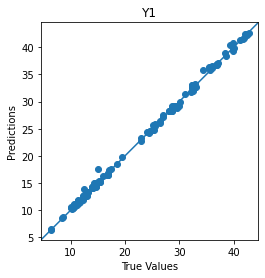

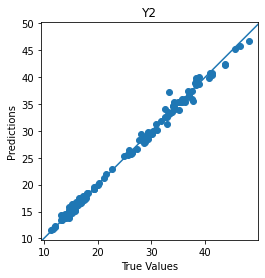

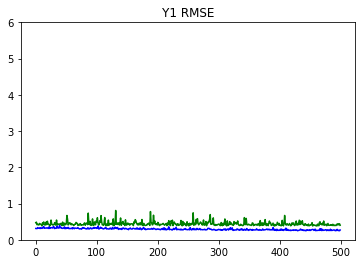

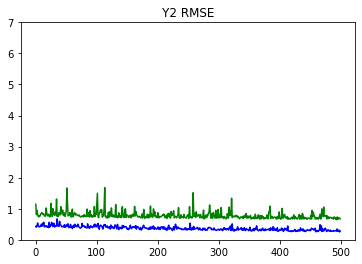

In [35]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)

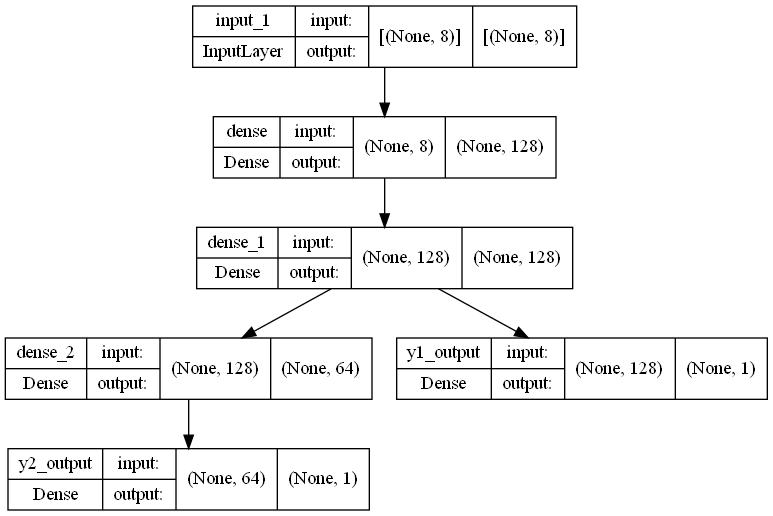

In [38]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')